In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import datetime
import requests
import numpy as np
import pandas as pd
from glob import glob
from bs4 import BeautifulSoup as bs

In [3]:
def dt(isodate):
    'Helper function to turn ISO date string into datetime object.'
    return datetime.datetime.strptime(isodate, '%Y-%m-%d')

In [4]:
def memeorandum_clusters(date, time='1200'):
    'Get clusters of Memeorandum news stories for a date (default is noon EST).'
    _url = 'https://www.memeorandum.com/{}/h{}'
    lnk = _url.format(date.strftime('%y%m%d'), time)
    r = requests.get(lnk)
    r.raise_for_status()
    s = bs(r.text)
    return s.find('div', {'class': 'nornbody'}).findAll('div', {'class': 'clus'})

In [5]:
def cluster_lead_data(clus):
    'Get data for the lead story in a cluster.'
    lead_headline = clus.find('div', {'class': 'ii'}).find('strong').text
    lead_link = clus.find('div', {'class': 'ii'}).find('strong').find('a')['href']
    lead_author = clus.find('cite').text.split('/')[0].strip().strip(':')
    lead_pub = clus.find('cite').find('a').text
    return lead_author, lead_pub, lead_headline, lead_link

In [6]:
def df_for_date(date):
    'Generate a data frame of lead news stories for specified date.'
    data = map(cluster_lead_data, memeorandum_clusters(date))
    df = pd.DataFrame(list(data), columns=['author', 'publication', 'headline', 'url'])
    df = df.reset_index().rename(columns={'index': 'rank'})
    df['rank'] = df['rank'] + 1
    df['date'] = date
    return df

In [7]:
for date in pd.date_range('2018-06-19', '2019-05-30'):
    outfile = 'data/{}.csv'.format(date.date().isoformat())
    if not os.path.exists(outfile):
        df_for_date(date).to_csv(outfile, encoding='utf8')

In [8]:
stories = pd.concat(pd.read_csv(f, index_col=0, parse_dates=['date']) for f in glob('data/*.csv')).set_index('date')

In [9]:
stories['aoc'] = stories['headline'].map(lambda x: 1 if 'ocasio-cortez' in x.lower() or 'aoc' in x.lower() else 0)

In [11]:
stories[stories['aoc'] == 1].sample(3)

,rank,author,publication,headline,url,aoc
date,,,,,,
2019-02-06,8,Vinson Cunningham,New Yorker,Alexandria Ocasio-Cortez Captured the Horror o...,http://www.newyorker.com/news/current/alexandr...,1
2019-04-13,10,The Babylon Bee,The Babylon Bee,"Ocasio-Cortez Appears On ‘The Price Is Right,’...",http://babylonbee.com/news/ocasio-cortez-appea...,1
2019-01-04,2,Colby Hall,Mediaite,Alexandria Ocasio-Cortez Suggests Super Wealth...,http://www.mediaite.com/tv/alexandria-ocasio-c...,1


In [12]:
weekly = stories.resample('W').agg({'headline': 'count',
                                         'aoc': sum})

In [13]:
daily = stories.resample('D').agg({'headline': 'count',
                                         'aoc': sum})

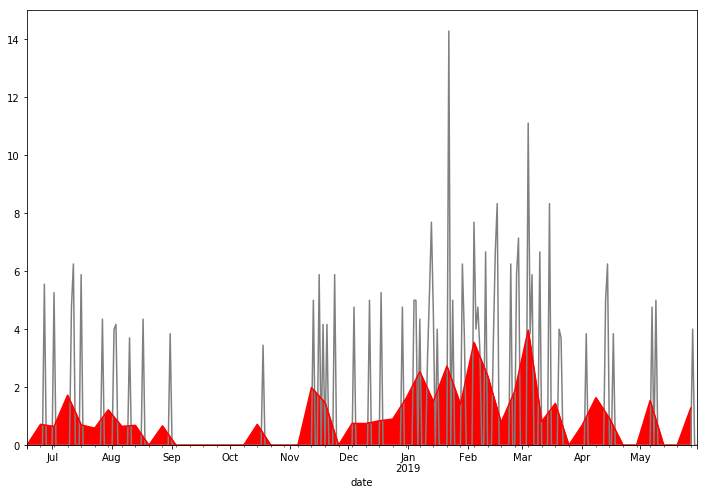

In [14]:
plt.figure(figsize=(12,8))

(100 * daily['aoc'] / daily['headline']).plot(kind='line', color='gray')
(100 * weekly['aoc'] / weekly['headline']).plot(kind='area', color='red')